In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 20, 12

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(30)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.254:41871 Dashboard: http://10.148.0.254:8787/status,Cluster Workers: 50 Cores: 200 Memory: 2500.00 GB


_________
# Read dataset


In [24]:
Nf = 720

data_dir = '/home1/scratch/xyu/mit_nc_t/'

filenames_Eta = sorted(glob(data_dir+'Eta_*.nc'))
filenames_Eta = filenames_Eta[:Nf]
%time ds_Eta = xr.open_mfdataset(filenames_Eta, concat_dim='time', compat='equals', decode_cf=False)

filenames_SSU = sorted(glob(data_dir+'SSU_*.nc'))
filenames_SSU = filenames_SSU[:Nf]
%time ds_SSU = xr.open_mfdataset(filenames_SSU, concat_dim='time', compat='equals', decode_cf=False)

filenames_SSV = sorted(glob(data_dir+'SSV_*.nc'))
filenames_SSV = filenames_SSV[:Nf]
%time ds_SSV = xr.open_mfdataset(filenames_SSV, concat_dim='time', compat='equals', decode_cf=False)

%time grid = xr.open_dataset('/home1/scratch/xyu/mit_grid.nc', decode_coords=False)

CPU times: user 4.71 s, sys: 1.81 s, total: 6.52 s
Wall time: 6.67 s
CPU times: user 4.94 s, sys: 1.76 s, total: 6.7 s
Wall time: 6.77 s
CPU times: user 4.75 s, sys: 1.72 s, total: 6.47 s
Wall time: 6.55 s
CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 24.6 ms


In [25]:
%time ds = xr.merge([ds_Eta, ds_SSU, ds_SSV, grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].nbytes / 1e9))

CPU times: user 24.5 s, sys: 1.6 s, total: 26.1 s
Wall time: 40.3 s
<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 720)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    dtime    (time) int64 dask.array<shape=(720,), chunksize=(1,)>
    Eta      (time, face, j, i) float32 dask.array<shape=(720, 13, 4320, 4320), chunksize=(1, 13, 4320, 4320)>
    SSU      (time, face, j, i_g) float32 dask.array<shape=(720, 13, 4320, 4320), chunksize=(1, 13, 4320, 4320)>
    SSV      (time, face, j_g, i) float32 dask.array<shape=(720, 1

In [26]:
E_dir = '/home1/scratch/xyu/momentum/'

---


# 1. Time derivative of SSU ($G_u$)

A central difference is applied to compute du/dt.

In [32]:
for face in range(ds['face'].size):
    
    d_SSU_dt_time = ( ds['SSU'].isel(face=face).shift(time=-1) - ds['SSU'].isel(face=face).shift(time=1) )/2/3600
    d_SSU_dt_time = d_SSU_dt_time.rename('d_SSU_dt_time')
    d_SSU_dt_time.to_dataset().to_zarr(E_dir+'d_SSU_dt_f%02d.nc'% (face), mode='w')
    print('face=%d - allready processed'%(face))

face=0 - allready processed
face=1 - allready processed
face=2 - allready processed
face=3 - allready processed
face=4 - allready processed
face=5 - allready processed
face=6 - allready processed
face=7 - allready processed
face=8 - allready processed
face=9 - allready processed
face=10 - allready processed
face=11 - allready processed
face=12 - allready processed


In [8]:
d_SSU_dt_time = ( ds['SSU'].shift(time=-1) - ds['SSU'].shift(time=1) )/2/3600
d_SSU_dt_time = d_SSU_dt_time.rename('d_SSU_dt_time')
print(d_SSU_dt_time)
d_SSU_dt_time.to_dataset().to_zarr(E_dir+'d_SSU_dt.nc', mode='w')

<xarray.DataArray 'd_SSU_dt_time' (time: 720, face: 13, j: 4320, i_g: 4320)>
dask.array<shape=(720, 13, 4320, 4320), dtype=float32, chunksize=(1, 13, 4320, 4320)>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...


_______

# 2. Coriolis terms ($G_u^{fv}$)

Next we create a `Grid` object from the dataset.
We need to tell xgcm that the `X` and `Y` axes are periodic.
(The other axes will be assumed to be non-periodic.)

In [15]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center

In [16]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_j = grid.interp(f,'Y')

In [ ]:
for face in range(ds['face'].size):

    dxgSSV_j = grid.interp(ds.dxG.isel(face=face) * ds['SSV'].isel(face=face),'Y') 
    dxgSSV_ji = grid.interp(dxgSSV_j,'X')    # SSV at (i_g,j)
    zeta_3 = (grid.diff(ds.dyC.isel(face=face) * ds['SSV'].isel(face=face),'X') - grid.diff(ds.dxC.isel(face=face) * ds['SSU'].isel(face=face),'Y'))/ds.rAz.isel(face=face) # relative vorticity  
    Coriolis_u = (f_j.isel(face=face) + grid.interp(zeta_3,'Y')) * dxgSSV_ji /ds.dxC.isel(face=face)    #(f+zeta)*SSV
    Coriolis_u = np.real(Coriolis_u).rename('Coriolis_u')
    Coriolis_u = Coriolis_u.chunk({'time': 1,'i_g':4320,'j':4320})
    Coriolis_u.to_dataset().to_zarr(E_dir+'Coriolis_u_f%02d.nc'% (face), mode='w')
    print('face=%d - allready processed'%(face))

# 3. Gradient of Bernoulli function

In [18]:
for face in range(ds['face'].size):

    g = 9.81
    KE = (grid.interp(ds['SSU'].isel(face=face)**2,'X') + grid.interp(ds['SSV'].isel(face=face)**2,'Y'))/2 # KE
    dB_dx = (grid.diff(g*ds['Eta'].isel(face=face),'X') + grid.diff(KE,'X'))/ds.dxC.isel(face=face)     # d(Eta*g + KE)/dx
    dB_dx = np.real(dB_dx).rename('dB_dx')    
    dB_dx = dB_dx.chunk({'time': 1,'i_g':4320,'j':4320})
    dB_dx.to_dataset().to_zarr(E_dir+'dB_dx_f%02d.nc'% (face), mode='w')
    print('face=%d - allready processed'%(face))

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


face=0 - allready processed
face=1 - allready processed
face=2 - allready processed
face=3 - allready processed
face=4 - allready processed
face=5 - allready processed
face=6 - allready processed
face=7 - allready processed
face=8 - allready processed
face=9 - allready processed
face=10 - allready processed
face=11 - allready processed
face=12 - allready processed


# 4. Residuals

In [28]:
D = [xr.open_zarr(E_dir+'d_SSU_dt_f%02d.nc'%(face)) for face in range(13)]
ds_tmp = xr.concat(D, dim='face')
print(ds_tmp)

<xarray.Dataset>
Dimensions:        (face: 13, i_g: 4320, j: 4320, time: 720)
Coordinates:
  * i_g            (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j              (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * time           (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
  * face           (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    d_SSU_dt_time  (face, time, j, i_g) float32 dask.array<shape=(13, 720, 4320, 4320), chunksize=(1, 1, 4320, 4320)>


In [29]:
D = [xr.open_zarr(E_dir+'Coriolis_u_f%02d.nc'%(face)) for face in range(13)]
ds_Coriolis = xr.concat(D, dim='face')
print(ds_Coriolis)

<xarray.Dataset>
Dimensions:     (face: 13, i_g: 4320, j: 4320, time: 720)
Coordinates:
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time        (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
  * face        (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Coriolis_u  (face, j, i_g, time) float32 dask.array<shape=(13, 4320, 4320, 720), chunksize=(1, 4320, 4320, 1)>


In [30]:
D = [xr.open_zarr(E_dir+'dB_dx_f%02d.nc'%(face)) for face in range(13)]
ds_B = xr.concat(D, dim='face')
print(ds_B)

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 4320, j: 4320, time: 720)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    dB_dx    (face, time, j, i_g) float32 dask.array<shape=(13, 720, 4320, 4320), chunksize=(1, 1, 4320, 4320)>


In [31]:
%time ds = xr.merge([ds_tmp,ds_Coriolis,ds_B])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.52 ms
<xarray.Dataset>
Dimensions:        (face: 13, i_g: 4320, j: 4320, time: 720)
Coordinates:
  * i_g            (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j              (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * time           (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
  * face           (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    d_SSU_dt_time  (face, time, j, i_g) float32 dask.array<shape=(13, 720, 4320, 4320), chunksize=(1, 1, 4320, 4320)>
    Coriolis_u     (face, j, i_g, time) float32 dask.array<shape=(13, 4320, 4320, 720), chunksize=(1, 4320, 4320, 1)>
    dB_dx          (face, time, j, i_g) float32 dask.array<shape=(13, 720, 4320, 4320), chunksize=(1, 1, 4320, 4320)>

 data size: 2096.2 GB


In [34]:
for face in range(ds['face'].size):

    residuals_u = ds['d_SSU_dt_time'] - ds['Coriolis_u'] + ds['dB_dx']
    residuals_u = np.real(residuals_u).rename('residuals_u').sel(face=face)  
    print(residuals_u)
    residuals_u = residuals_u.chunk({'time': 1,'i_g':4320,'j':4320})
    residuals_u.to_dataset().to_zarr(E_dir+'residuals_u_f%02d.nc'% (face), mode='w')
    print('face=%d - allready processed'%(face))

<xarray.DataArray 'residuals_u' (time: 720, j: 4320, i_g: 4320)>
dask.array<shape=(720, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320)>
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    face     int64 0
face=0 - allready processed


In [35]:
D = [xr.open_zarr(E_dir+'residuals_u_f%02d.nc'%(face)) for face in range(13)]
ds_residuals = xr.concat(D, dim='face')
print(ds_residuals)

<xarray.Dataset>
Dimensions:      (face: 13, i_g: 4320, j: 4320, time: 720)
Coordinates:
  * i_g          (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * j            (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time         (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
  * face         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    residuals_u  (face, time, j, i_g) float32 dask.array<shape=(13, 720, 4320, 4320), chunksize=(1, 1, 4320, 4320)>


In [36]:
%time ds = xr.merge([ds,ds_residuals])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.01 ms
<xarray.Dataset>
Dimensions:        (face: 13, i_g: 4320, j: 4320, time: 720)
Coordinates:
  * i_g            (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j              (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * time           (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
  * face           (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    d_SSU_dt_time  (face, time, j, i_g) float32 dask.array<shape=(13, 720, 4320, 4320), chunksize=(1, 1, 4320, 4320)>
    Coriolis_u     (face, j, i_g, time) float32 dask.array<shape=(13, 4320, 4320, 720), chunksize=(1, 4320, 4320, 1)>
    dB_dx          (face, time, j, i_g) float32 dask.array<shape=(13, 720, 4320, 4320), chunksize=(1, 1, 4320, 4320)>
    residuals_u    (face, time, j, i_g) float32 dask.array<shape=(13, 720, 4320, 4320), chunksize=(1, 1, 4320, 4320)>

 data size: 2794.9 GB


# 5. Figures

In [ ]:
face_1 = 1

fig = plt.figure(figsize = (24,12))

plt.subplot(221)
ds['Coriolis_u'].isel(face= face_1,time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(222)
ds['d_SSU_dt_time'].isel(face= face_1,time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(223)
ds['dB_dx'].isel(face= face_1,time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)
plt.subplot(224)
ds['residuals_u'].isel(face= face_1,time=80).plot(vmin=-0.0001, vmax=0.0001, cmap = cm.balance)

In [ ]:
# std
residuals_u_std = ds['residuals_u'].isel(face=face_1,i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()
Coriolis_u_std = ds['Coriolis_u'].isel(face=face_1,i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()
dB_dx_std = ds['dB_dx'].isel(face=face_1,i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()
d_SSU_dt_time_std = ds['d_SSU_dt_time'].isel(face=face_1,i_g=slice(500,1500),j=slice(500,2000)).std(['i_g','j']).load()

(0, 2.5e-05)

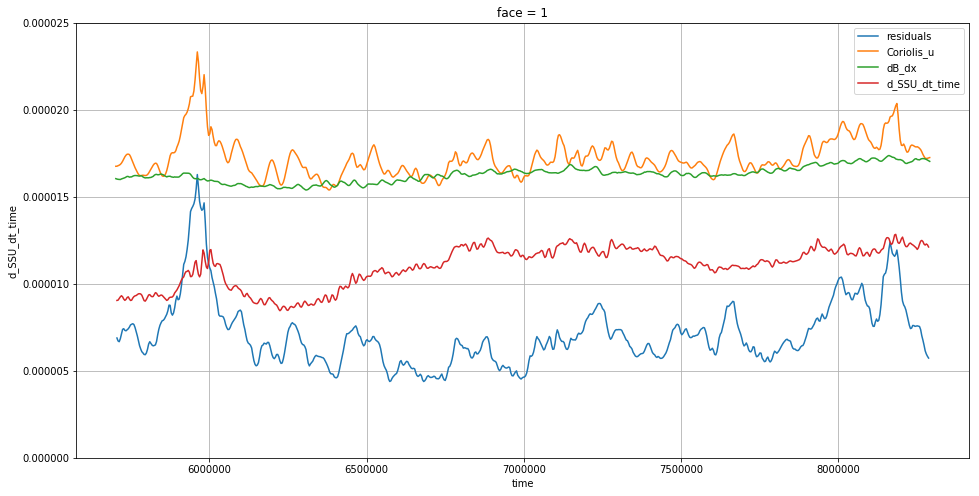

In [39]:
# std
fig, ax = plt.subplots(figsize=(16,8))
labels = ['residuals', 'Coriolis_u','dB_dx','d_SSU_dt_time']

residuals_u_std.plot(ax=ax, label=labels[0])
Coriolis_u_std.plot(ax=ax, label=labels[1])
dB_dx_std.plot(ax=ax, label=labels[2])
d_SSU_dt_time_std.plot(ax=ax, label=labels[3])
ax.legend(); ax.grid()
#ax.set_xlim([0,480])
ax.set_ylim([0,2.5*1e-5])

In [67]:
cluster.scheduler.close()

<Future finished result=None>